In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import gdown
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import hashlib
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras_tuner import HyperParameters
from tensorflow import keras
import tensorflow as tf
from google.colab import files

In [ ]:
drive.mount('/content/drive')

# Google Drive file ID (from the shared link)
file_id = "1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e"
file_name = "train_images.zip"
file_path = "/content/" + file_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)
print(f"Downloaded: {file_path}")

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e
From (redirected): https://drive.google.com/uc?id=1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e&confirm=t&uuid=5f717156-86cf-4c44-9c84-93ef50faf1aa
To: /content/train_images.zip
100%|██████████| 820M/820M [00:12<00:00, 64.0MB/s]

Downloaded: /content/train_images.zip


In [ ]:
!unzip -q $file_path -d /content/extracted_folder

In [ ]:
src_root = '/content/extracted_folder/train_images'
dst_root = '/content/images_all'

os.makedirs(dst_root, exist_ok=True)

for label_folder in os.listdir(src_root):
    subdir = os.path.join(src_root, label_folder)
    if os.path.isdir(subdir):
        for filename in os.listdir(subdir):
            src_file = os.path.join(subdir, filename)
            dst_file = os.path.join(dst_root, filename)
            shutil.copy2(src_file, dst_file)

In [ ]:
metadata_path = '/content/meta_train.csv'

df = pd.read_csv(metadata_path)

def map_age_to_group(age):
    if 45 <= age <= 49:
        return '45-49'
    elif 50 <= age <= 54:
        return '50-54'
    elif 55 <= age <= 59:
        return '55-59'
    elif 60 <= age <= 64:
        return '60-64'
    elif 65 <= age <= 69:
        return '65-69'
    elif 70 <= age <= 74:
        return '70-74'
    else:
        return '75+'

df['age_group'] = df['age'].apply(map_age_to_group)

for group in df['age_group'].unique():
    os.makedirs(os.path.join(dst_root, group), exist_ok=True)

for _, row in df.iterrows():
    src_path = os.path.join(dst_root, row['image_id'])
    dst_path = os.path.join(dst_root, row['age_group'], row['image_id'])

    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)

print("Done !")


Done !


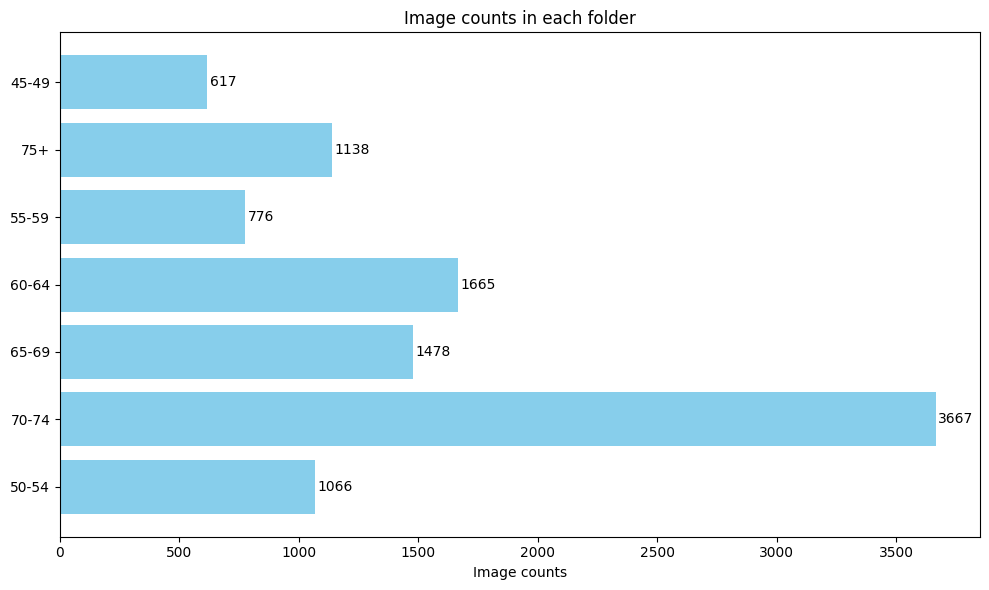

In [ ]:
data = []
for label in os.listdir(dst_root):
    label_path = os.path.join(dst_root, label)
    if os.path.isdir(label_path):
        count = len([file for file in os.listdir(label_path) if file.endswith(".jpg")])
        data.append({"label": label, "count": count})

df_counts = pd.DataFrame(data)

plt.figure(figsize=(10,6))
bars = plt.barh(df_counts['label'], df_counts['count'], color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             str(width), va='center', fontsize=10)

plt.xlabel("Image counts")
plt.title("Image counts in each folder")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm

def compute_md5(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def remove_duplicates_in_folder(folder_path):
    seen_hashes = set()
    duplicates = []

    for filename in tqdm(os.listdir(folder_path), desc=f'Checking {folder_path}'):
        file_path = os.path.join(folder_path, filename)

        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        file_hash = compute_md5(file_path)

        if file_hash in seen_hashes:
            duplicates.append(file_path)
        else:
            seen_hashes.add(file_hash)

    for dup_path in duplicates:
        os.remove(dup_path)

    print(f'Removed {len(duplicates)} duplicates in {folder_path}')

for category in os.listdir(dst_root):
    category_path = os.path.join(dst_root, category)
    if os.path.isdir(category_path):
        remove_duplicates_in_folder(category_path)

Checking /content/images_all/45-49: 100%|██████████| 617/617 [00:00<00:00, 7030.62it/s]


Removed 2 duplicates in /content/images_all/45-49


Checking /content/images_all/75+: 100%|██████████| 1138/1138 [00:00<00:00, 6090.76it/s]


Removed 9 duplicates in /content/images_all/75+


Checking /content/images_all/55-59: 100%|██████████| 776/776 [00:00<00:00, 6805.40it/s]


Removed 4 duplicates in /content/images_all/55-59


Checking /content/images_all/60-64: 100%|██████████| 1665/1665 [00:00<00:00, 5713.42it/s]


Removed 10 duplicates in /content/images_all/60-64


Checking /content/images_all/65-69: 100%|██████████| 1478/1478 [00:00<00:00, 6871.21it/s]


Removed 10 duplicates in /content/images_all/65-69


Checking /content/images_all/70-74: 100%|██████████| 3667/3667 [00:00<00:00, 6336.06it/s]


Removed 27 duplicates in /content/images_all/70-74


Checking /content/images_all/50-54: 100%|██████████| 1066/1066 [00:00<00:00, 5790.29it/s]

Removed 12 duplicates in /content/images_all/50-54


In [ ]:
def split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2):
    images = [f for f in os.listdir(category_path) if f.lower().endswith('.jpg')]

    train_images, val_images = train_test_split(images, test_size=test_size, random_state=42)

    category_name = os.path.basename(category_path)

    os.makedirs(os.path.join(train_dir, category_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category_name), exist_ok=True)

    for img in train_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(train_dir, category_name, img))

    for img in val_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(val_dir, category_name, img))

    print(f"{category_name}: {len(train_images)} train, {len(val_images)} val")

train_dir = '/content/data/train'
val_dir = '/content/data/val'

for category in os.listdir(dst_root):
    category_path = os.path.join(dst_root, category)
    if os.path.isdir(category_path):
        split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2)

45-49: 492 train, 123 val
75+: 903 train, 226 val
55-59: 617 train, 155 val
60-64: 1324 train, 331 val
65-69: 1174 train, 294 val
70-74: 2912 train, 728 val
50-54: 843 train, 211 val


In [ ]:
def count_images_per_class(dataset_path, ext=".jpg"):
    category_counts = {}
    for category in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, category)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.endswith(ext)]
            category_counts[category] = len(image_files)
    return category_counts

def resample_to_mean(dataset_path, ext=".jpg"):
    random.seed(42)

    counts = count_images_per_class(dataset_path, ext)
    values = list(counts.values())
    mean_sample = math.floor(sum(values) / len(values))

    print(f"[INFO] Mean sample count: {mean_sample}\n")

    for category, count in counts.items():
        if count >= mean_sample:
            print(f"[SKIP] {category}: {count} images (>= mean)")
            continue

        print(f"[RESAMPLE] {category}: {count} → {mean_sample}")
        class_path = os.path.join(dataset_path, category)
        images = [f for f in os.listdir(class_path) if f.endswith(ext)]

        i = 0
        while len([f for f in os.listdir(class_path) if f.endswith(ext)]) < mean_sample:
            img_name = random.choice(images)
            src_path = os.path.join(class_path, img_name)
            new_filename = f"resample_{i}_{img_name}"
            dst_path = os.path.join(class_path, new_filename)
            shutil.copy(src_path, dst_path)
            i += 1

        print(f"[DONE] {category}: now has {mean_sample} images.\n")

resample_to_mean(train_dir)

[INFO] Mean sample count: 1180

[RESAMPLE] 45-49: 492 → 1180
[DONE] 45-49: now has 1180 images.

[RESAMPLE] 75+: 903 → 1180
[DONE] 75+: now has 1180 images.

[RESAMPLE] 55-59: 617 → 1180
[DONE] 55-59: now has 1180 images.

[SKIP] 60-64: 1324 images (>= mean)
[RESAMPLE] 65-69: 1174 → 1180
[DONE] 65-69: now has 1180 images.

[SKIP] 70-74: 2912 images (>= mean)
[RESAMPLE] 50-54: 843 → 1180
[DONE] 50-54: now has 1180 images.



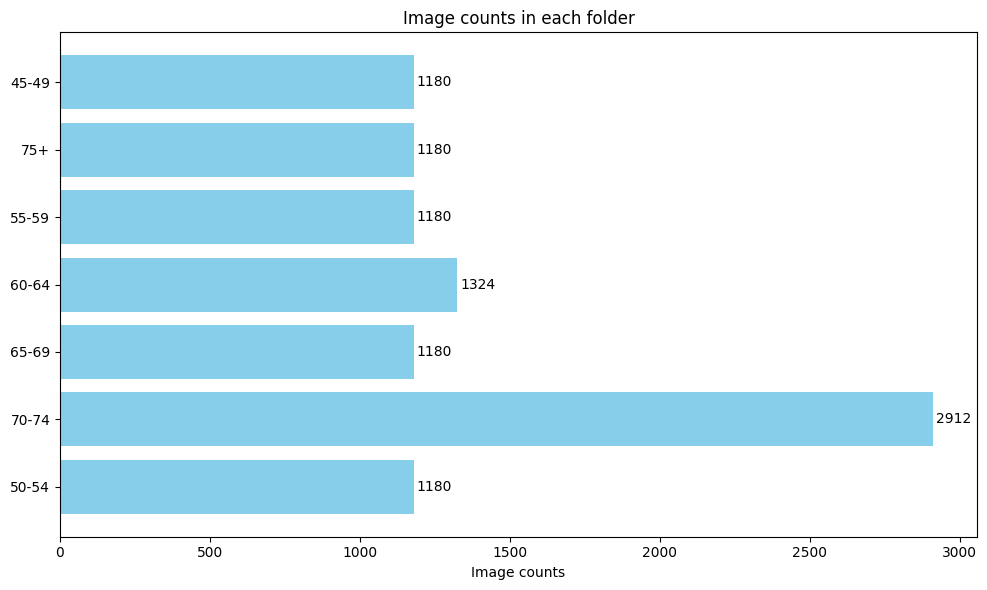

In [ ]:
data = []
for label in os.listdir('/content/data/train'):
    label_path = os.path.join('/content/data/train', label)
    if os.path.isdir(label_path):
        count = len([file for file in os.listdir(label_path) if file.endswith(".jpg")])
        data.append({"label": label, "count": count})

df_counts = pd.DataFrame(data)

plt.figure(figsize=(10,6))
bars = plt.barh(df_counts['label'], df_counts['count'], color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             str(width), va='center', fontsize=10)

plt.xlabel("Image counts")
plt.title("Image counts in each folder")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(299, 299),
    batch_size=64,
    class_mode='categorical'
)

Found 10136 images belonging to 7 classes.
Found 2068 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.layers import (BatchNormalization, Activation)

def build_model(hp):
    base_model = InceptionV3(weights=None, include_top=False, input_shape=(299, 299, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense Block 1
    x = Dense(
        units=hp.Int('dense1_units', min_value=256, max_value=1024, step=128)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(hp.Float('dropout_rate1', min_value=0.2, max_value=0.5, step=0.1))(x)

    # Dense Block 2
    x = Dense(
        units=hp.Int('dense2_units', min_value=64, max_value=512, step=64)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(hp.Float('dropout_rate2', min_value=0.1, max_value=0.4, step=0.1))(x)

    # Output Layer
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    directory='kt_bayesian',
    project_name='rice_variety_tuning'
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
dense1_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 128, 'sampling': 'linear'}
dropout_rate1 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense2_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout_rate2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0005, 0.0001], 'ordered': True}


In [ ]:
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
768               |768               |dense1_units
0.3               |0.3               |dropout_rate1
448               |448               |dense2_units
0.4               |0.4               |dropout_rate2
0.0001            |0.0001            |learning_rate



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.2987 - loss: 1.9737 - val_accuracy: 0.0986 - val_loss: 2.5104 - learning_rate: 1.0000e-04
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.4462 - loss: 1.5654 - val_accuracy: 0.4221 - val_loss: 1.9242 - learning_rate: 1.0000e-04
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.5174 - loss: 1.3814 - val_accuracy: 0.4512 - val_loss: 1.7354 - learning_rate: 1.0000e-04
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 312s 976ms/step - accuracy: 0.5821 - loss: 1.1703 - val_accuracy: 0.5305 - val_loss: 1.5492 - learning_rate: 1.0000e-04
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 310s 979ms/step - accuracy: 0.6545 - loss: 0.9827 - val_accuracy: 0.5140 - val_loss: 1.7571 - learning_rate: 1.0000e-04
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.6840 - loss: 0.9028
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
317/317 ━━━━━━━━━━━━━━━━━━━━ 309s 976ms/step 

KeyboardInterrupt: 

In [ ]:
best_hps = HyperParameters()
best_hps.Fixed('dense1_units', 768)
best_hps.Fixed('dropout_rate1', 0.3)
best_hps.Fixed('dense2_units', 448)
best_hps.Fixed('dropout_rate2', 0.4)
best_hps.Fixed('learning_rate', 0.0001)

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stopping, reduce_lr])

# Save the best model
best_model.save("best_rice_age_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.3017 - loss: 1.9634 - val_accuracy: 0.1209 - val_loss: 2.6858 - learning_rate: 1.0000e-04
Epoch 2/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.4416 - loss: 1.6103 - val_accuracy: 0.5208 - val_loss: 1.9735 - learning_rate: 1.0000e-04
Epoch 3/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.5144 - loss: 1.4093 - val_accuracy: 0.4831 - val_loss: 1.7493 - learning_rate: 1.0000e-04
Epoch 4/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.5688 - loss: 1.2360 - val_accuracy: 0.5430 - val_loss: 1.6100 - learning_rate: 1.0000e-04
Epoch 5/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 317s 998ms/step - accuracy: 0.6266 - loss: 1.0872 - val_accuracy: 0.4918 - val_loss: 1.9954 - learning_rate: 1.0000e-04
Epoch 6/25
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.6832 - loss: 0.9074
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
317/317 ━━━━━━━━━━━━━━━━━━━━ 317s 999ms/step - a